# Courbes de niveau

## Table des matières

- Préambule

  - Dépendances logicielles

  - Différentiation automatique

- Ensembles de niveau : exemples de référence

- Construction des courbes de niveau

  - Méthode de Newton

  - Génération des points

  - Bouclage et auto-intersection 

- Calcul de l'aire d'un ensemble de sous-niveau

  - Méthode des carrés

  - Méthodes des triangles

## Préambule

### Dépendances logicielles 

In [41]:
# Autograd & Numpy
import autograd
import autograd.numpy as np

# Pandas
import pandas as pd

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 5] # [width, height] (inches). 

# Jupyter & IPython
from IPython.display import display

### Différentation automatique

On définit ici deux fonctions utilitaires, `grad` et `J`, permettant de calculer simplement le gradient d'une fonction scalaire de deux variables réelles et la matrice jacobienne d'une fonction vectorielle de deux variables réelles.

In [2]:
def grad(f):
    g = autograd.grad
    def grad_f(x, y):
        return np.array([g(f, 0)(x, y), g(f, 1)(x, y)])
    return grad_f

In [3]:
def J(f):
    j = autograd.jacobian
    def J_f(x, y):
        return np.array([j(f, 0)(x, y), j(f, 1)(x, y)]).T
    return J_f

Exemples d'usage :

In [4]:
def f(x, y):
    return np.sin(x) + 2.0 * np.sin(y)

grad_f = grad(f)

grad_f(1.0, 0.0) # array([1., 2.])
g = autograd.grad
print(g(f,0)(0.0,0.0))

1.0


In [5]:
def f(x, y):
    return np.array([x + 2 * y, 3 * x + 4 * y])

J_f = J(f)

J_f(0.0, 0.0) # array([[1., 2.], [3., 4.]])

array([[1., 2.],
       [3., 4.]])

## Ensembles de niveau : exemples de référence

On appelle *ensemble de niveau* $c \in \mathbb{R}$ d'une fonction $f : \mathbb{R}^2 \to \mathbb{R}$  l'ensemble du plan
$$
\{(x,y) \in \mathbb{R}^2 \; | \; f(x, y) = c\}.
$$


On définit ici quelques fonctions qui pourront servir de référence pour valider les algorithmes de génération de courbes de niveau. On pourra également utiliser la fonction utilitaire `display_contour` ci-dessous, qui exploite [la fonction `contour` de Matplotlib](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contour.html) pour représenter une collection d'ensembles de niveau.

In [6]:
def display_contour(f, x, y, levels):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    ax.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")

#### Fonction quadratique

In [7]:
def f1(x, y):
    x = np.array(x)
    y = np.array(y)
    return 3.0 * x * x - 2.0 * x * y + 3.0 * y * y 

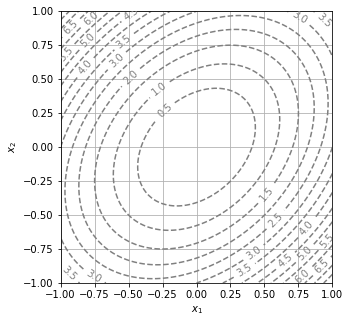

In [8]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=15 # 10 levels, automatically selected
)

#### Fonction de Rosenbrock

Source : [Fonction de Rosenbrock, Wikipédia](https://en.wikipedia.org/wiki/Rosenbrock_function)

$$
f_2 : (x,y) \in \mathbb{R}^2 \mapsto (x - 1)^2 + (x - y^2)^2
$$

In [9]:
def f2(x, y):
    return (x - 1)**2 + (x - y**2)**2

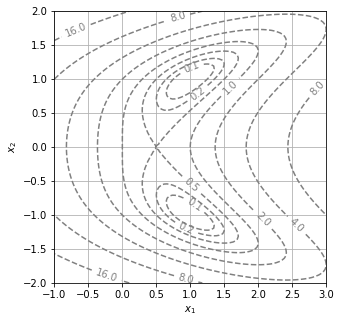

In [10]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

#### Fonction complexe

Source: [Courbe implicite, Wikipédia](https://en.wikipedia.org/wiki/Implicit_curve)

In [11]:
def f3(x, y):
    return np.sin(x + y) - np.cos(x * y) - 1 + 0.001 * (x * x + y * y) 

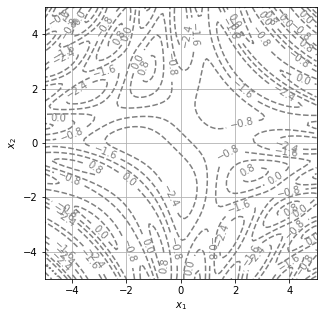

In [12]:
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

## Construction des courbes de niveau

### Méthode de Newton

Afin de trouver des points sur des courbes de niveau, on souhaite implémenter un algorithme de résolution des équations de la forme $F(x,y) = 0$ où $F: \mathbb{R}^2 \to \mathbb{R}^2$, par la méthode de Newton, amorcée par un point de référence $(x_0,y_0) \in \mathbb{R}^2$.

L'implémentation prendra la forme générale donnée ci-dessous. L'appel `x, y = Newton(F, x0, y0, eps, N)` devra renvoyer le couple des coordonnées d'un point $(x, y)$ qui est une solution approchée de $F(x,y)=0$ à proximité de $(x_0, y_0)$. La qualité de l'approximation produite est déterminée par le réel positif $\varepsilon > 0$, une approximation de la distance entre le point $(x,y)$ renvoyé par la fonction et la solution exacte. L'algorithme itératif s'interrompra si aucune approximation de la précision souhaitée n'a été trouvée en $N$ étapes. 

**Question** L'application à laquelle nous destinons la fonction `Newton` demande-t'elle une grande précision ?
Choisir une valeur de `eps` qui semble raisonnable et justifier l'ordre de grandeur choisi.

In [13]:
N = 100
eps = 10**-3

# Ici on veut seulement afficher des données sur un graphique. 
#Le graphique le plus "précis" jusqu'ici était gradué de 0.25 en 0.25. On prend donc une précision égale à 10**-3 

**Question** Implémenter la fonction `Newton` en complétant le canevas ci-dessous

In [14]:
def Newton(F, x0, y0, eps=eps, N=N):
    x, y =x0, y0  # Notre point initial
    for i in range(N):
        Jac = J(F)(x, y)
        if np.linalg.det(Jac) == 0:
            raise ValueError(f"Jacobienne non inversible au point {x, y}")
        else:
            A = np.dot(np.linalg.inv(Jac),F(x,y))
            x -= A[0]
            y -= A[1]
            if np.sqrt((x - x0)**2 + (y - y0)**2) <= eps:  # La distance au point cherché est plus petite que epsilon
                return x, y
            x0, y0 = x, y
    else:
        raise ValueError(f"no convergence in {N} steps.")

**Question** Tester votre implémentation de la fonction `Newton` ! On suggère par exemple de l'utiliser pour chercher un point $(x, y)$ de la ligne de niveau $0.8$ de $f_1$ (cf. Exemples de référence) qui vérifie en outre $x = y$ en utilisant le point $(0.8, 0.8)$. Puis de faire varier le point de référence, la contrainte supplémentaire, etc. et de représenter graphiquement les résultats.

Pour tous les graphiques qui vont suivre on trace en gris les courbes de niveau, en rouge la droite d'équation x=y (ou autre contrainte supplémentaire) et en bleu le point renvoyé par la fonction Newton

Influence du point initial :
Point initial : (0.8, 0.8)


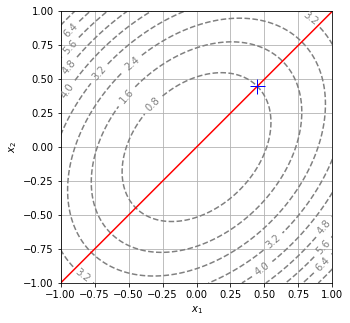

Point initial : (0.7, 0.9)


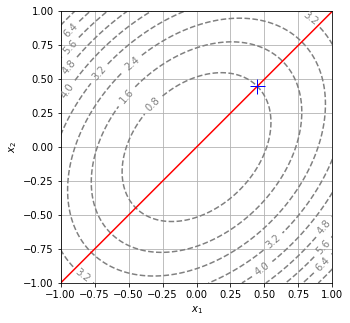

Point initial : (0.9, 1.0)


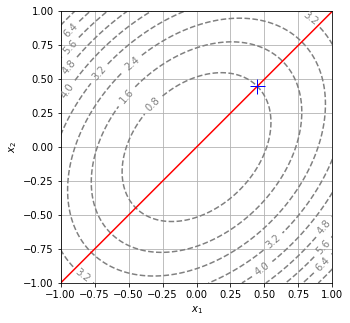



Influence de epsilon
epsilon égal à 0.001


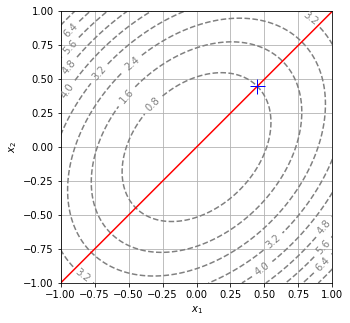

epsilon égal à 0.01


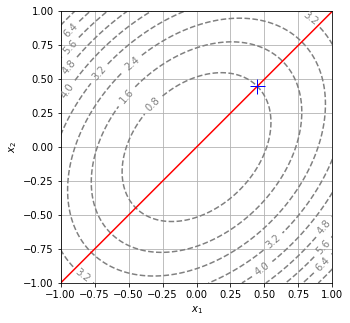

epsilon égal à 0.1


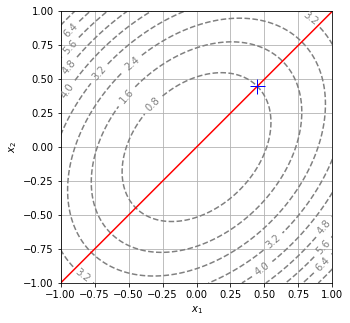

epsilon égal à 1


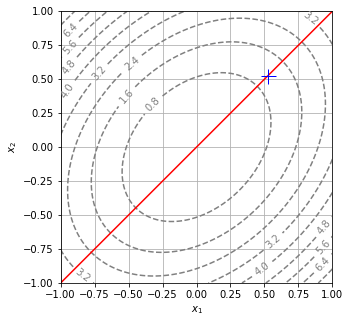

On ne remarque donc pas de très grandes influences des paramètres sur la précision de la solution. On peut cependant voir que le 'signe' du point initial influe sur le point solution retourné par notre fonction
point de départ : (0.8, 0.8)


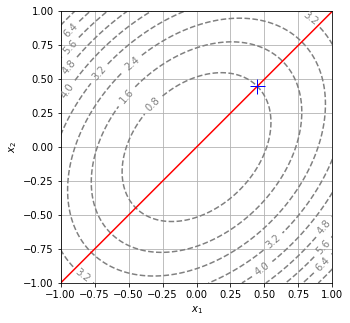

point de départ : (-0.8, -0.8)


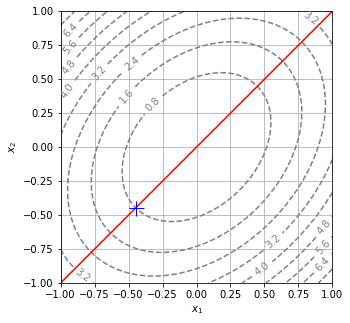

On peut s'amuser à changer la contrainte supplémentaire, par exemple avec y = x**2


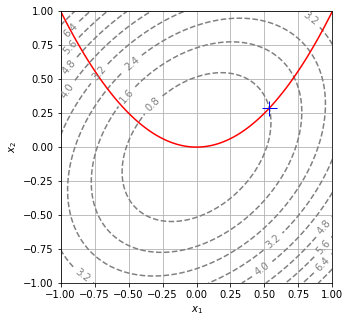

In [15]:
def F(x,y):
    # Fonction dont on va chercher le zéro
    return np.array([0.8 - f1(x, y), y - x])

def affichage(f,X,x0,y0,ep=eps):
    # gère l'affichage des courbes de niveau, de la contrainte et du point retourné par la fonction Newton
    display_contour(f, x=X, y=X, levels=10)
    plt.plot(X,X,'r')
    Ne = Newton(F, x0, y0,ep)
    plt.plot(Ne[0],Ne[1],'+b',markersize=15)
    plt.show()
    

X=np.linspace(-1.0, 1.0, 100)
print("Pour tous les graphiques qui vont suivre on trace en gris les courbes de niveau, en rouge la droite d'équation x=y (ou autre contrainte supplémentaire) et en bleu le point renvoyé par la fonction Newton")
print("\nInfluence du point initial :")
for Pt in [(0.8,0.8),(0.7,0.9),(0.9,1.0)]:
    print(f"Point initial : {Pt}")
    affichage(f1,X,Pt[0],Pt[1])
    
print("\n\nInfluence de epsilon")
for ep in [10**-3,10**-2,10**-1,1]:
    print(f"epsilon égal à {ep}")
    affichage(f1,X,0.8,0.8,ep)

print("On ne remarque donc pas de très grandes influences des paramètres sur la précision de la solution. On peut cependant voir que le 'signe' du point initial influe sur le point solution retourné par notre fonction")
for signe in [1,-1]:
    x0, y0 = signe*0.8,signe*0.8
    print(f"point de départ : {(x0,y0)}")
    affichage(f1,X,x0,y0)

print("On peut s'amuser à changer la contrainte supplémentaire, par exemple avec y = x**2")
display_contour(f1, x=X, y=X, levels=10)
plt.plot(X,X**2,'r')
def F2(x,y):
    return np.array([0.8 - f1(x, y), y - x**2])
Ne = Newton(F2, 0.8, 0.8)
plt.plot(Ne[0],Ne[1],'+b',markersize=15)
plt.show()

### Génération des points

**Question** Comment, en partant d'un point de référence $(x_0, y_0)$ tel que $f(x_0, y_0)=c$, peut-on générer avec la méthode de Newton un point $(x_1, y_1)$ également tel que $f(x_1, y_1) = c$, mais à une distance $\delta > 0$ de $(x_0, y_0)$ et qui soit "à droite" quand on est en $(x_0, y_0)$ et qu'on regarde dans la direction de $\nabla f(x_0, y_0)$ ? Implémenter la fonction `level_curve` qui répète ce procédé $N-1$ fois et renvoie un tableau NumPy de taille $2 \times N$ contenant les coordonnées des points correspondants.

On trace 10 points successifs pour reconstituer le début de la courbe de niveau


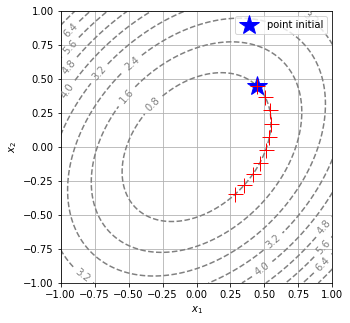

On trace jusqu'à N = 100 pour retracer toute la courbe


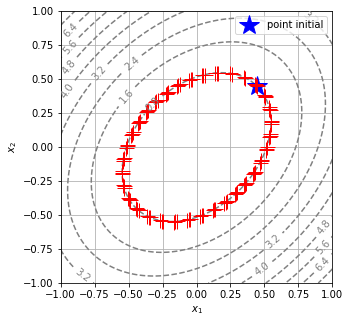

on laisse matplotlib lisser la courbe


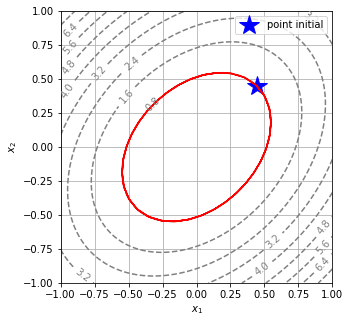

In [16]:
#On veut trouver un des deux points d'intersection de la courbe de niveau et du cercle de centre (x0, y0) de rayon delta
def distance(x1, y1, x2, y2):
    # Retourne la distance entre les points (x1, y1) et (x2, y2)
    return np.sqrt((x1 - x2)**2 + (y1 - y2)**2)

def level_curve(f, x0, y0, delta=0.1, N=10, eps=eps):
    c = f(x0,y0) #altitude considérée
    x1, y1 = x0, y0
    Ret = np.empty((N,2))
    Ret[0,:]=np.array([x0,y0])
    def F2(x, y): #Fonction dont on veut trouver le zéro
        return np.array([c - f(x, y), delta - distance(x1, y1, x, y)])
    for i in range(N-1):
        x1, y1=Ret[i,:]
        gr = 0.1*grad(f)(x1, y1)
        x, y = Newton(F2, x1+gr[1], y1-gr[0],eps) # On prend un point initial à droite du point précédent en lui ajoutant le gradiant "tourné à droite" de pi/2
        Ret[i+1,:]=np.array([x, y])
    return Ret

print("On trace 10 points successifs pour reconstituer le début de la courbe de niveau")
X=np.linspace(-1.0, 1.0, 100)
display_contour(f1, x=X, y=X, levels=10)
Ne = Newton(F, 0.8, 0.8)
PT = level_curve(f1, Ne[0], Ne[1],delta=0.1)
plt.plot(Ne[0],Ne[1],'*b',markersize=20,label='point initial')
plt.plot(PT[:,0],PT[:,1],'+r',markersize=15)
plt.legend()
plt.show()

print("On trace jusqu'à N = 100 pour retracer toute la courbe")
display_contour(f1, x=X, y=X, levels=10)
PT = level_curve(f1, Ne[0], Ne[1], N=100, delta=0.1)
plt.plot(Ne[0],Ne[1],'*b',markersize=20,label='point initial')
plt.plot(PT[:,0],PT[:,1],'+r',markersize=15)
plt.legend()
plt.show()

print("on laisse matplotlib lisser la courbe")
display_contour(f1, x=X, y=X, levels=10)
PT = level_curve(f1, Ne[0], Ne[1], N=100, delta=0.1)
plt.plot(Ne[0],Ne[1],'*b',markersize=20,label='point initial')
plt.plot(PT[:,0],PT[:,1],'r')
plt.legend()
plt.show()

### Bouclage et auto-intersection

L'algorithme précédent est malheureusement susceptible de faire plusieurs fois le tour d'une courbe de niveau donnée. 

**Question** Proposer une nouvelle implémentation de `level_curve` qui évite ce problème. 

In [17]:
def level_curve(f, x0, y0, delta=0.1, eps=eps):
    c, i = f(x0,y0), 0
    L=[[x0,y0]] # Liste des points que l'on retournera
    x1, y1 = x0, y0
    def F2(x, y):
        return np.array([c - f(x, y), delta - distance(x1, y1, x, y)])
    while distance(x0,y0,L[-1][0],L[-1][1])>delta-eps or i<1: #On s'arrête si on revient dans le cercle de centre (x0, y0) et de rayon delta
        if i>=10000:
            # On évite une boucle infinie en se limitant à 10000 points
            raise ValueError("La méthode ne boucle pas après 10000 itérations")
        i+=1
        x1, y1=L[-1]
        gr = 0.1*grad(f)(x1, y1)
        x, y = Newton(F2, x1+gr[1], y1-gr[0],eps)
        L.append([x, y])
    L.append([x0, y0])
    Ret = np.array(L)
    return Ret

**Question** Valider graphiquement le résultat au moyen des exemples de référence.

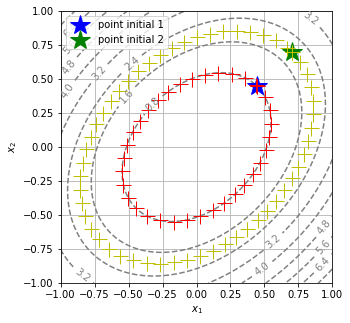

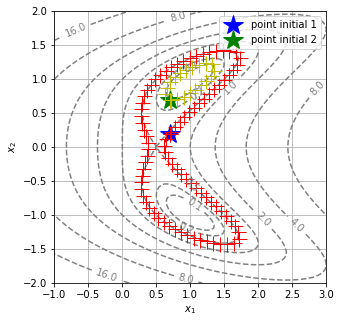

In [18]:
colors = ['*b','+r','*g','+y']

def tracer(M,f):
    for i in range(len(M)):
        PT = level_curve(f, M[i][0], M[i][1],delta=0.1)
        plt.plot(M[i][0],M[i][1],colors[2*i],markersize=20,label=f'point initial {i+1}')
        plt.plot(PT[:,0],PT[:,1],colors[2*i+1],markersize=15)
    plt.legend()
    plt.show()
    

# Fonction f1
X=np.linspace(-1.0, 1.0, 100)
display_contour(f1, x=X, y=X, levels=10)
M=[Newton(F, 0.8, 0.8),np.array([0.7,0.7])]
tracer(M,f1)

# Fonction f2
X=np.linspace(-1.0, 3.0, 100)
Y=np.linspace(-2.0, 2.0, 100)
display_contour(f2, x=X, y=Y, levels=[2**i for i in range(-3, 8)])
M=[np.array([0.7,0.2]),np.array([0.7,0.7])]
tracer(M,f2)

# Calcul de l'aire d'un ensemble de sous-niveau
On cherche à estimer l'aire d'un ensemble délimité par une courbe fermée, approchée par une ligne brisée comme les ensemble de niveau décrits précédemment.

## Méthode des carrés
Considérons un tel ensemble $K$ décrit par l'équation $f(x_1,x_2)\leq c$.
Une première approche grossière, sans utiliser la description de la frontière obtenue précédemment, consiste à plonger l'ensemble  $K$ dans un domaine de forme simple (disons un carré pour fixer les idées), donc d'aire connue, à recouvrir le carré d'une grille uniforme constituée de petites cellules carrée de taille $h\times h$,  et d'estimer l'aire en fonction de la proportion du nombre de cellules dont le centre est  dans $K$. On obtient ainsi une approximation $A_h$ de l'aire de $K$. Lorsque $h$ tend vers $0$, on peut  s'attendre à ce que $A_h$ tende effectivement vers l'aire $A$ de $K$. 

**Question**  Coder une fonction `area_squares(f,c,h)` qui renvoie l'aire approchée de l'ensemble de sous-niveau de $f$ associée à $c$ à l'aide de la méthode des carrés pour un pas $h$. Appliquer cette méthode à l'estimation  de l'aire du disque unité et étudier numériquement le comportement de  $|A_h - A|$ quand $h$ tend vers $0$. (On pourra tracer une courbe de l'erreur fonction de $h$ en échelle log-log).

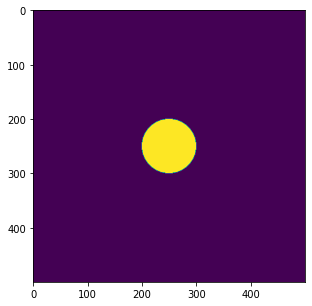

Aire calculée égale à 3.144
Aire théorique : 3.141592653589793


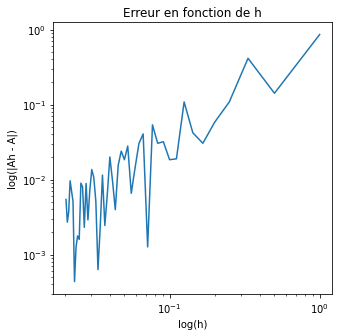

In [30]:
Longueur_Carte = 5 # Taille de la carte sur laquelle on va faire notre étude, fixée ici arbitrairement à 5.
# On aurait pu ici calculer cette taille dans notre fonction en prenant les valeurs minimales et maximales des abscisses/ordonnées
# des points renvoyés par la fonction level_curve, mais cela aurait un lourd impact sur la complexité de la fonction.
# On fait ici le choix d'afficher la carte obtenue avec en jaune l'aire calculée. Si le jaune "touche le bord" de la carte on laissera
# soin à l'utilisateur d'agrandir la valeur de Longueur_Carte.

def area_squares(f,c,h,show=False):
    def is_in_A(x, y):
        # teste si un point appartient à la zone dont on veut calculer l'aire
        return f(x, y)<=c
    X = np.arange(-Longueur_Carte+h/2,Longueur_Carte+h/2,h)
    Y = np.arange(-Longueur_Carte+h/2,Longueur_Carte+h/2,h)
    Z = np.transpose([np.tile(X, len(Y)), np.repeat(Y, len(X))]).reshape(len(X),len(Y),2) # Produit cartésien de X et Y
    # Z est une matrice de taille [n, n, 2] contenant les coordonnées des centres des carrés que l'on considère ici
    Ret = np.zeros((len(X),len(Y)),dtype=bool)
    for i in range(len(X)):
        for j in range(len(Y)):
            Ret[i,j]=is_in_A(Z[i,j,0],Z[i,j,1])
    if show:
        plt.imshow(Ret)
        plt.show()
    return Ret.sum()*h**2

def f(x,y):
    return distance(x, y, 0, 0)
A = area_squares(f,1,0.02,True)
print(f"Aire calculée égale à {A}")
print(f"Aire théorique : {np.pi}")

H = [10/n for n in range(10,500,10)]
L = [abs(np.pi - area_squares(f,1,h)) for h in H]
plt.plot(H, L)
plt.title("Erreur en fonction de h")
plt.xscale('log')
plt.xlabel('log(h)')
plt.yscale('log')
plt.ylabel('log(|Ah - A|)')
plt.show()

**Question**  Expliquer comment cette approche peut être modifiée pour obtenir un encadrement de l'aire recherchée. 
Appliquer cette approche à l'ensemble de sous niveau considéré précédemment, pour en donner un encadrement à $10^{-2}$ près.


In [42]:
# On peut avoir un encadrement de l'aire considérée en diminuant progressivement h jusqu'à obtenir deux valeurs éloignées de moins que beta
# Où beta est la précision recherchée
# Ceci est vrai car la suite |AireThéorique - Aire_h| est globalement décroissante avec h.

def encadrement_squares(f,c,beta,show=False):
    h, i = 0.1, 0
    A = area_squares(f,c,0.5,show)
    A2 = area_squares(f,c,h,show)
    while abs(A2-A)>beta:
        h/=3
        i+=1
        A = A2.copy()
        A2 = area_squares(f,c,h,show).copy()
        if i>9:
            raise ValueError("La méthode ne renvoit pas de résultat au bout de 10 itérations !")
    return A2

eA = encadrement_squares(f,1,10**-3)
print(f"Encadrement de pi à 10**-3 près : {eA}")



Encadrement de pi à 10**-3 près : 3.1417283950617283


## Méthode des triangles
On suppose maintenant que l'on dispose d'une description approchée de la frontière de l'ensemble $K$, sous la forme d'une suite "circulaire"  de points consécutifs:
$$
(x_0,y_0), (x_1,y_1), \dots, (x_N,y_N)= (x_0,y_0),
$$
par exemple la sortie de ``level_curve``.
On note $z_i = (x_i,y_i)$. Conformément à ce qui précède, on considére que la courbe fermée est décrite dans le sens anti-trigonométrique (sens des aiguilles d'une montre). On suppose dans un premier temps que l'ensemble $K$ est convexe. 
On se donne un point $p = (x_p,y_p)$ dans  l'intérieur de $K$, et l'on somme les aires des triangles $(p,z_{i+1},z_i)$. 
On obtient une approximation de l'aire de $K$, notée $B_N$.

**Question** Tester cette approche sur le disque unité. Etudier la convergence de $B_N$ vers $\pi$ lorsque la distance $\delta$ entre les points successifs de la courbe de niveau tend vers 0, et étudier numériquement la vitesse de cette convergence.  

In [43]:
from math import sqrt

In [44]:
def vector(x,y,z,x1,y1,z1):
    return [x1 - x, y1 - y, z1 - z] #renvoie les cd du vecteur PA

def scalar(v1,v2):
    return v1[0]*v2[0] + v1[1]*v2[1] + v1[2]*v2[2] #produit scalaire

def norm(v):
    return sqrt(scalar(v,v)) #norme

def cross(a, b):
    c = [a[1]*b[2] - a[2]*b[1],
         a[2]*b[0] - a[0]*b[2],
         a[0]*b[1] - a[1]*b[0]]
    return c #produit vectoriel

def area_triangles(resx, resy, xp, yp):
    A = 0
    l = len(resx)
    z = 0
    for i in range(0,l - 1):
        v1 = vector(xp, yp, z, resx[i], resy[i], z)
        v2 = vector(xp, yp, z, resx[i+1], resy[i+1], z)
        v = cross(v1,v2) #on calcule l'aire des triangles avec la norme du produit vecotriel, réduite ici à la valeur absolue de sa coordonée selon z
        A += -0.5*v[2] #les vecteurs étant parcourus en sens horaires, on doit avoir un signe - pour avoir la bonne valeur
    return A    

Aire du cercle calculée : 3.1415403248469205


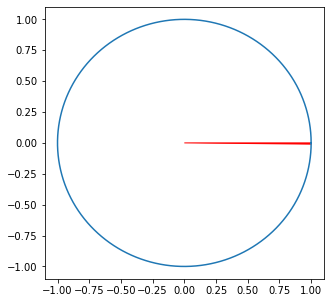

In [46]:
def circle(x,y):
    return x**2 + y**2
xp, yp = 0.,0.
resx, resy = level_curve(circle, 1., 0., 0.01)[:,0], level_curve(circle, 1., 0., 0.01)[:,1]
plt.plot(resx,resy)
T = np.array([[xp,yp],[resx[0],resy[0]],[resx[1],resy[1]]])
# On affiche le premier triangle dont l'aire est calculée
T1 = plt.Polygon(T, color= 'r')
plt.gca().add_patch(T1)
print(f"Aire du cercle calculée : {area_triangles(resx, resy, xp, yp)}")

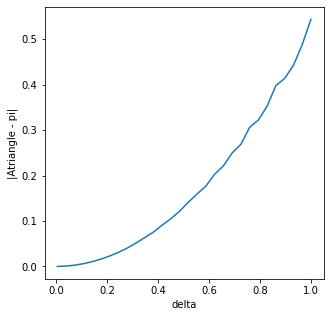

In [47]:
D = np.linspace(0.005,1,30)[::-1]
A=[]
for delta in D: #Pour tracer l'erreur en fonction de delta,
    resx, resy = level_curve(circle, 1., 0., delta)[:,0], level_curve(circle, 1., 0., delta)[:,1]
    A.append(abs(area_triangles(resx, resy, 0., 0.) - np.pi))
plt.plot(D, A)
plt.ylabel('|Atriangle - pi|')
plt.xlabel('delta')
plt.show()

**Question** Vérifier que l'approche (on prendra garde à accepter le fait qu'il puisse y avoir, dans le calcul des différentes aires,  des triangles d'aire négative) donne des résultats pertinents même si le point $p$ est  à l'extérieur de $K$. Donner une explication à ce bon comportement.

Aire retournée : 3.141579594219305


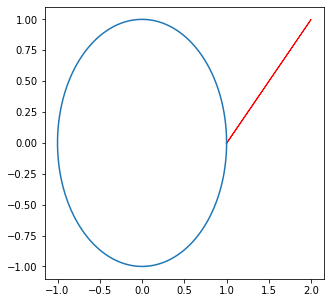

In [48]:
#Pour un point en dehors de K, le sens de parcours de la courbe change, ce qui change le signe du produit vectoriel et donc le
#signe de l'aire défini dans area_triangles. On annule ainsi les 'aires en trop' induites par le parcourt dans le premier sens
xp, yp = 2., 1. #on prend le point de coordonnées (2,1) à l'extérieur du cercle
resx, resy = level_curve(circle, 1., 0., delta)[:,0], level_curve(circle, 1., 0., delta)[:,1]
plt.plot(resx,resy)
T = np.array([[xp,yp],[resx[0],resy[0]],[resx[1],resy[1]]])#on affiche le premier triangle dont l'aire est calculée
T1 = plt.Polygon(T, color= 'r')
plt.gca().add_patch(T1)
print(f"Aire retournée : {area_triangles(resx, resy, xp, yp)}")

**Question** Vérifier le bon comportement de la méthode dans le cas où l'ensemble $K$ n'est pas convexe. On pourra considérer par exemple la réunion de deux disques, tous deux décrits par leur frontière discrétisée parcourue dans le sans anti-trigonométrique.

6.283080649693905


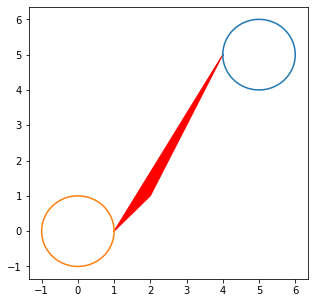

In [51]:
def circle(x,y):
    return x**2 + y**2
def circle2(x,y):
    return (x - 5)**2 + (y - 5)**2
resx, resy = level_curve(circle2, 4., 5., 0.01)[:,0] , level_curve(circle2, 4., 5., 0.01)[:,1]
resx2, resy2 = level_curve(circle, 1., 0., 0.01)[:,0] , level_curve(circle, 1., 0., 0.01)[:,1]
plt.plot(resx,resy)
plt.plot(resx2,resy2)
#pour vérifier si la méthode fonctionne on fait une concaténation, ce qui a le désaventage de crée un triangle en trop quand on
#passe d'un disque à l'autre. On peut donc l'enlever en retournant dans l'autre sens sur le premier disque on ajoute donc le premier
#point du premier disque.
resx3 = np.zeros(len(resx2)+1)
resy3 = np.zeros(len(resy2)+1)
resx3[-1] = resx[0]
resy3[-1] = resy[0]
resx3[:-1] = resx2
resy3[:-1] = resy2
Cx = np.concatenate((resx,resx3))
Cy = np.concatenate((resy,resy3))
print(area_triangles(Cx,Cy,xp,yp))
T = np.array([[xp,yp],[Cx[len(resx)-1],Cy[len(resy)-1]],[Cx[len(resx)],Cy[len(resy)]]])#on affiche le triangle à enlever
T1 = plt.Polygon(T, color= 'r')
plt.gca().add_patch(T1)

**Question** En déduire une fonction `area_triangles(x,y)` qui évalue l'aire d'une surface de niveau décrite par un ensemble de points $(x_i,y_i)$ de la courbe de niveau. Appliquer cette approche à l'ensemble de sous-niveau considéré précédemment, et vérifier que les deux méthodes (carrés et triangles) donnent des résultats cohérents entre elles. 
Comparer les méthodes entre elles, en précisant les avantages et défauts relatifs de chacune d'elles. 
(On pourra appuyer la réponse sur des tests numériques ainsi que sur des arguments théoriques)

In [49]:
import time

In [52]:
#l'aire ne dépendant pas du point choisi, on prend arbitrairement l'origine pour la fonction 
def area_triangles_bis(x,y):
    A = 0
    l = len(x)
    z = 0
    for i in range(0,l - 1):
        v1 = vector(0., 0., z, x[i], y[i], z)
        v2 = vector(0., 0., z, x[i+1], y[i+1], z)
        v = cross(v1,v2)
        A += -0.5*v[2] 
    return A 
print(area_triangles_bis(Cx,Cy))

6.283080649693872


In [53]:
#Test pour le cercle unité
t1 = time.time()
A1 = area_squares(circle, 1, 0.02)
dt1 = time.time() - t1
t3 = time.time()
resx, resy = level_curve(circle, 1., 0., 0.01)[:,0], level_curve(circle, 1., 0., 0.01)[:,1]
dt3 = time.time() - t3
t2 = time.time()
A2 = area_triangles_bis(resx,resy)
dt2 = time.time() - t2
print(f"on trouve un écart à pi de {A1 - np.pi} pour les carrés contre {A2 - np.pi} pour les triangles")
print(f"le temps d'éxection est de {dt1} s pour les carrés contre {dt2} s pour les triangles, sans compter level_curve, {dt2 + dt3} s si on compte level_curve")

on trouve un écart à pi de 0.002407346410207012 pour les carrés contre -5.2328742872642664e-05 pour les triangles
le temps d'éxection est de 0.7781002521514893 s pour les carrés contre 0.016038894653320312 s pour les triangles, sans compter level_curve, 11.891611099243164 s si on compte level_curve


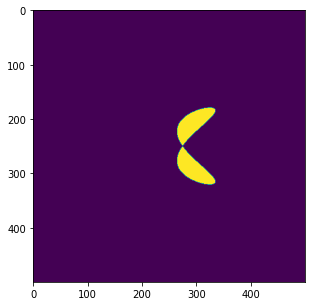

1.8800000000000001 temps éxécution 1.377549648284912 s


In [54]:
t = time.time()
c = area_squares(f2, 0.5, 0.02, True)
dt = time.time() - t
print(c, f"temps éxécution {dt} s")

In [55]:
x, y = level_curve(f2, 0.7, 0.2)[:,0], level_curve(f2, 0.7, 0.2)[:,1]
t = time.time()
c = area_triangles_bis(x,y)
dt = time.time() - t
print(c, f"temps éxécution {dt} s")

2.027100799752628 temps éxécution 0.0 s


In [57]:
'''Conclusions:
    -la méthode des triangle est plus rapide si on ne compte pas le besoin de tracer la courbe
    -la fiabilité dépend fortement des divers pas → il est difficile de déterminer si une méthode est plus fiable que l'autre
    -les deux méthodes ont des résultats cohérents mais qui restent assez sensibles au pas des deux fonctions'''

"Conclusions:\n    -la méthode des triangle est plus rapide si on ne compte pas le besoin de tracer la courbe\n    -la fiabilité dépend fortement des divers pas → il est difficile de déterminer si une méthode est plus fiable que l'autre\n    -les deux méthodes ont des résultats cohérents mais qui restent assez sensibles au pas des deux fonctions"